In [25]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Insert file path, Using Colab so used drive to access the .csv
csv_path = "/content/drive/MyDrive/Colab Notebooks/Resources/coin_Cardano.csv"

In [4]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [5]:
df = df.sort_values('Date')

In [6]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Cardano,ADA,2017-10-02 23:59:59,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
1,2,Cardano,ADA,2017-10-03 23:59:59,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2,3,Cardano,ADA,2017-10-04 23:59:59,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
3,4,Cardano,ADA,2017-10-05 23:59:59,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
4,5,Cardano,ADA,2017-10-06 23:59:59,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


In [7]:
df.shape

(1374, 10)

Text(0, 0.5, 'Close Price (USD)')

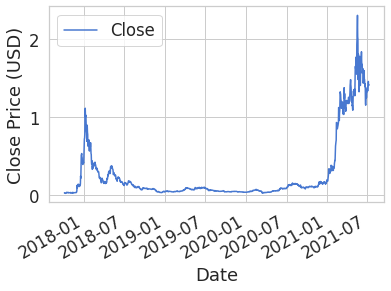

In [8]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [9]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [10]:
scaled_close.shape

(1374, 1)

In [11]:
np.isnan(scaled_close).any()

False

In [12]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [13]:
scaled_close = scaled_close.reshape(-1, 1)

In [14]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [15]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [16]:
X_train.shape

(1210, 99, 1)

In [17]:
X_test.shape

(64, 99, 1)

# Model

In [26]:
# Bidirectional Recurrent Neural Net Framework.... Work in Progress. Adjust code as needed.
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))


# Training

In [27]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [28]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Train on 1089 samples, validate on 121 samples
Epoch 1/50
1089/1089 [==============================] - 11s 10ms/sample - loss: 0.0037 - val_loss: 0.1116
Epoch 2/50
1089/1089 [==============================] - 3s 2ms/sample - loss: 0.0051 - val_loss: 0.0959
Epoch 3/50
1089/1089 [==============================] - 3s 2ms/sample - loss: 0.0029 - val_loss: 0.0958
Epoch 4/50
1089/1089 [==============================] - 3s 2ms/sample - loss: 0.0031 - val_loss: 0.0890
Epoch 5/50
1089/1089 [==============================] - 3s 3ms/sample - loss: 0.0028 - val_loss: 0.0458
Epoch 6/50
1089/1089 [==============================] - 3s 2ms/sample - loss: 0.0020 - val_loss: 0.0205
Epoch 7/50
1089/1089 [==============================] - 3s 2ms/sample - loss: 0.0015 - val_loss: 0.0103
Epoch 8/50
1089/1089 [==============================] - 3s 2ms/sample - loss: 8.2415e-04 - val_loss: 0.0257
Epoch 9/50
1089/1089 [==============================] - 3s 3ms/sample - loss: 6.3198e-04 - val_loss: 0.1446
Epoch 1

In [29]:
model.evaluate(X_test, y_test)

64/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.012495424132794142

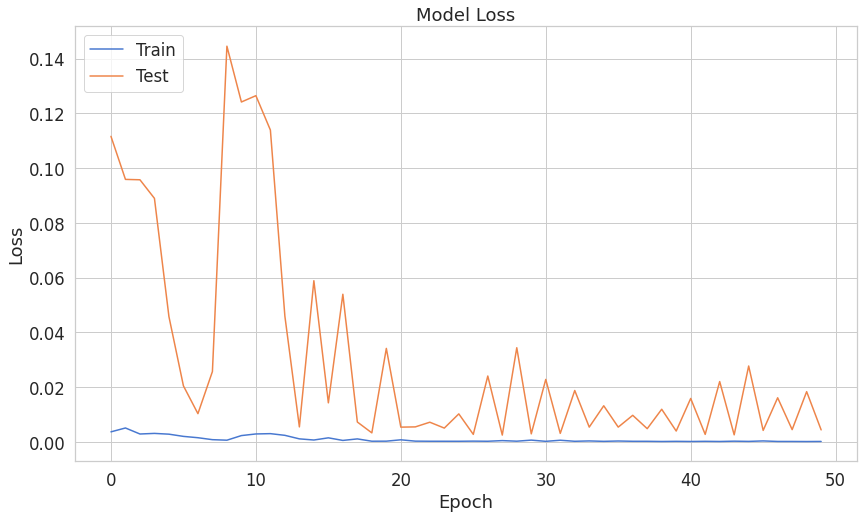

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction

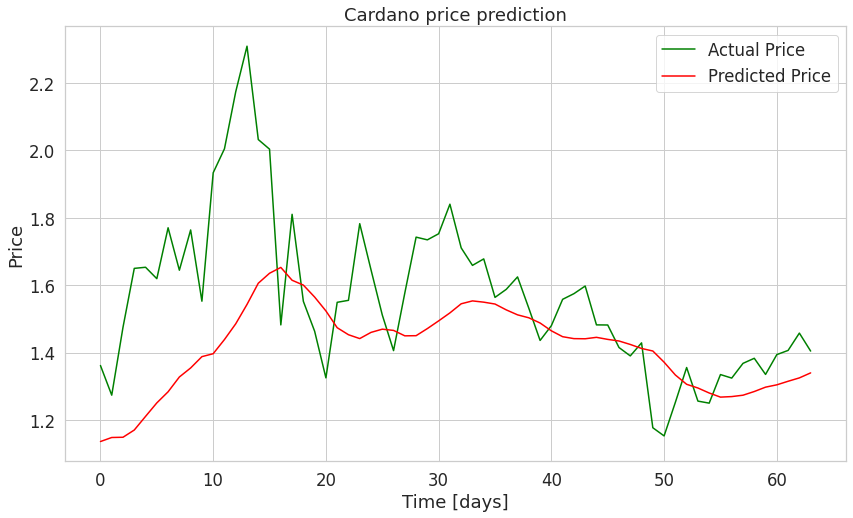

In [31]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Cardano price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();